In [74]:
import MPPIController
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")
sns.set_palette("tab10")

# Block on a slope

Try MPPI controller with a simple block on a slope.

In [89]:
class BlockOnSlope:
    # Apply a force parallel to the slope to achieve a desired position
    # and velocity of the block
    
    def __init__(self, initial_state, block_mass, slope_angle, g, dt, mu_k=0):
        self.initial_state = initial_state
        self.desired_state = None
        self.block_mass = block_mass
        self.slope_angle = slope_angle
        self.g = g
        self.dt = dt
        self.mu_k = mu_k
        self.nx, self.nu = (2, 1)
        
        self.controller = MPPIController.MPPIController(
            n_rollouts=200,
            horizon_length=10,
            exploration_cov=np.array([[10 ** 2]]),
            exploration_lambda=5,
            nx=self.nx,
            nu=self.nu,
            terminal_cost=self.terminal_cost,
            state_cost=self.state_cost,
            control_cost=self.control_cost,
            evolve_state=self.evolve_state,
            dt=dt
        )

    def terminal_cost(self, x):
        error = (self.desired_state - x)
        Q = np.array([[3, 0], [0, 1]])
        
        return error.T @ Q @ error

    def state_cost(self, x):
        error = (self.desired_state - x)
        Q = np.array([[1, 0], [0, 1]])
        
        return error.T @ Q @ error

    def control_cost(self, u, noise):
        noisy_control = u + noise
        R = np.diag([0.5 * 1e-2])

        return noisy_control.T @ R @ noisy_control

    def evolve_state(self, x, u, dt):
        pos, vel = x
        accel = (self.g * np.sin(self.slope_angle)) + (u[0] / self.block_mass)
        
        newvel = vel + accel * dt
        newpos = pos + newvel * dt + 0.5 * accel * (dt ** 2)
        
        evolved_state = np.array([newpos, newvel])

        return evolved_state

    def simulator(self, x, u):
        return self.evolve_state(x, u, dt=dt)

In [90]:
dt = 1 / 10

block_env = BlockOnSlope(
    initial_state=np.array([0, 0]),
    block_mass=5,               # kg
    slope_angle=np.radians(30), # radians
    g=-9.81,                     # m / s^2
    dt=dt                       # s
)

block_env.desired_state = np.array([10, 0])

[MPPI] [Warn] No control range input. Assuming [-inf, inf] on all dimensions.


In [91]:
# Create lists to store control sequence and state sequences for MPPI runs
control_seq, states = [], []

simulation_length = 10  # s
n_steps = int((1 / dt) * simulation_length)

# Begin simulation
current_state = block_env.initial_state

for _ in range(0, n_steps):
    action = block_env.controller.step(current_state)
    current_state = block_env.simulator(current_state, action)
    
    states.append(current_state[0])
    control_seq.append(action)

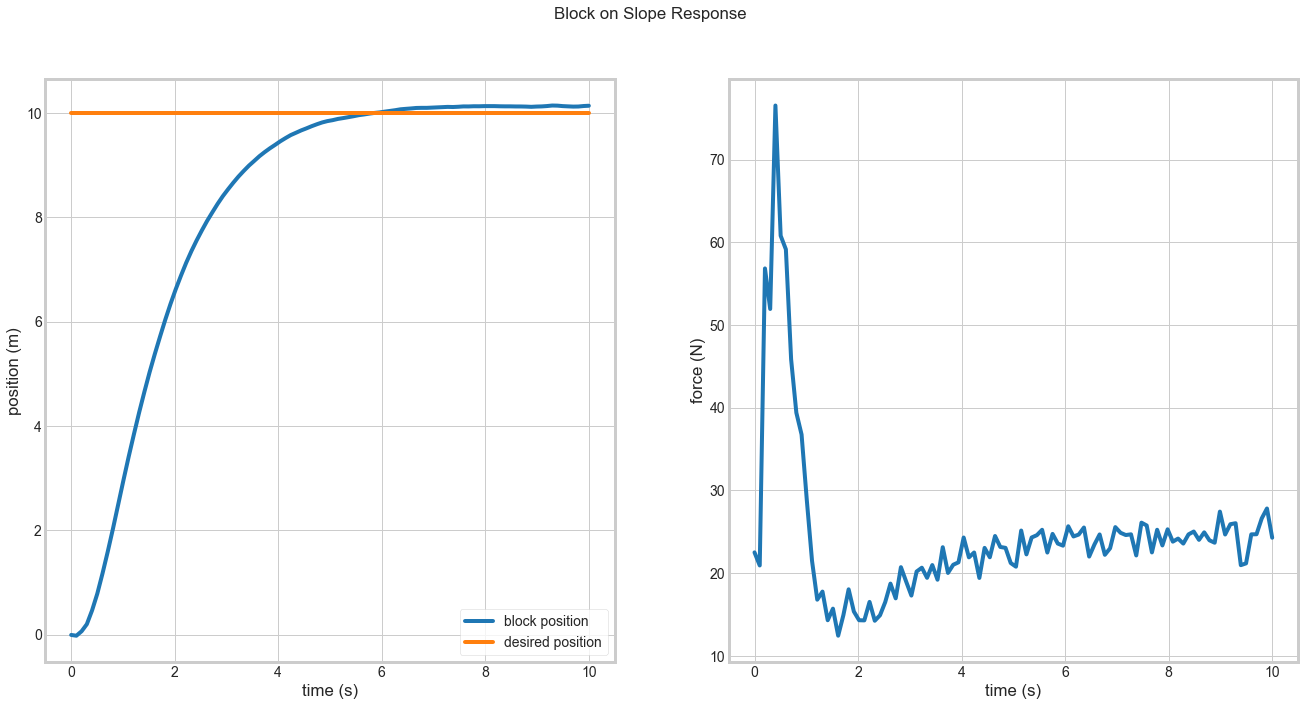

In [92]:
# Plot the results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle("Block on Slope Response")

time = np.linspace(0, simulation_length, n_steps)

ax1.plot(time, states, label="block position")
ax1.plot(time, np.repeat(block_env.desired_state[0], n_steps), label="desired position")
ax1.set(xlabel="time (s)", ylabel="position (m)")
ax1.legend()

ax2.plot(time, control_seq, label="control")
ax2.set(xlabel="time (s)", ylabel="force (N)")

plt.show()

# Inverted pendulum
Try MPPI controller with an inverted pendulum.

In [93]:
class InvertedPendulum:
    def __init__(self, initial_state, m, l, g, dt):
        self.initial_state = initial_state
        self.desired_state = None
        self.m = m
        self.l = l
        self.g = g
        self.dt = dt
        self.nx, self.nu = (2, 1)
                        
        self.controller = MPPIController.MPPIController(
            n_rollouts=200,
            horizon_length=20,
            exploration_cov=np.diag([0.75 ** 2]),
            exploration_lambda=1e-2,
            nx=self.nx,
            nu=self.nu,
            terminal_cost=self.terminal_cost,
            state_cost=self.state_cost,
            evolve_state=self.evolve_state,
            dt=dt,
            control_range={"min": np.array([-5]), "max": np.array([5])},
                control_noise_initialization = MPPIController.ControlNoiseInit.RANDOM
        )
        
        self.measurement_noise_cov = np.array([
            [(3 * np.pi / 180) ** 2]  # 5 degrees of measurement noise
        ])
            
    def terminal_cost(self, x):
        error = (self.desired_state - x)
        Q = np.array([[1e3, 0], [0, 1]])
        
        return error.T @ Q @ error

    def state_cost(self, x):
        error = (self.desired_state - x)
        Q = np.array([[3, 0], [0, 1]])
        
        return error.T @ Q @ error

    def evolve_state(self, x, u, dt):
        th, thdot = x

        newthdot = thdot + (3.0 * self.g / (2.0 * self.l) * np.sin(th) + 3.0 / (self.m * self.l**2) * u[0]) * dt        
        newth = th + newthdot * dt
        
        evolved_state = np.array([newth, newthdot])
        
        return evolved_state
    
    def simulator(self, x, u, measurement_noise=False):
        curr_state = self.evolve_state(x, u, dt=self.dt)
        if measurement_noise:
            noise = np.random.multivariate_normal(np.zeros_like(u), cov=self.measurement_noise_cov,
                                                  size=1)[0]
            curr_state += noise
        
        return curr_state

In [94]:
dt = 1 / 10

inv_pend_env = InvertedPendulum(
    initial_state=np.array([np.pi/2, 0]),
    m=1,     # kg
    l=1,     # m
    g=-9.81, # m / s^2
    dt=dt    # s
)

inv_pend_env.desired_state = np.array([0, 0])

In [95]:
# Create lists to store control sequence and state sequences for MPPI runs
control_seq, states = [], []

simulation_length = 8  # s
n_steps = int((1 / dt) * simulation_length)

# Begin simulation
current_state = inv_pend_env.initial_state

for _ in range(0, n_steps):
    action = inv_pend_env.controller.step(current_state)
    current_state = inv_pend_env.simulator(current_state, action, measurement_noise=True)
    
    states.append(current_state[0])
    control_seq.append(action)

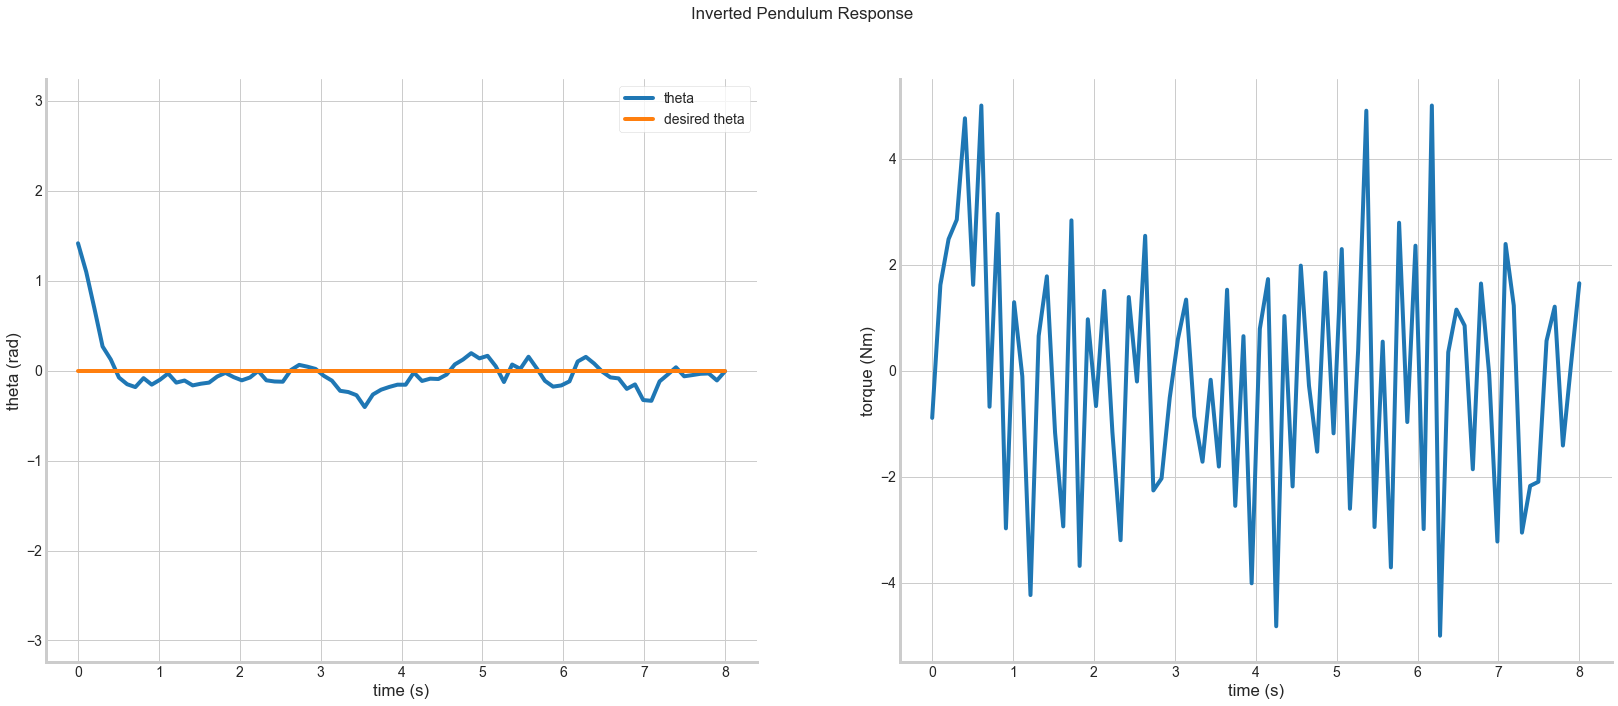

In [96]:
# Plot the results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(25, 10))
sns.despine()

fig.suptitle("Inverted Pendulum Response")

time = np.linspace(0, simulation_length, n_steps)

ax1.plot(time, states, label="theta")
ax1.plot(time, np.repeat(inv_pend_env.desired_state[0], n_steps), label="desired theta")
ax1.set(xlabel="time (s)", ylabel="theta (rad)")
ax1.set_ylim([-np.pi-0.1, np.pi+0.1])
ax1.legend()

ax2.plot(time, control_seq, label="control")
ax2.set(xlabel="time (s)", ylabel="torque (Nm)")

plt.show()